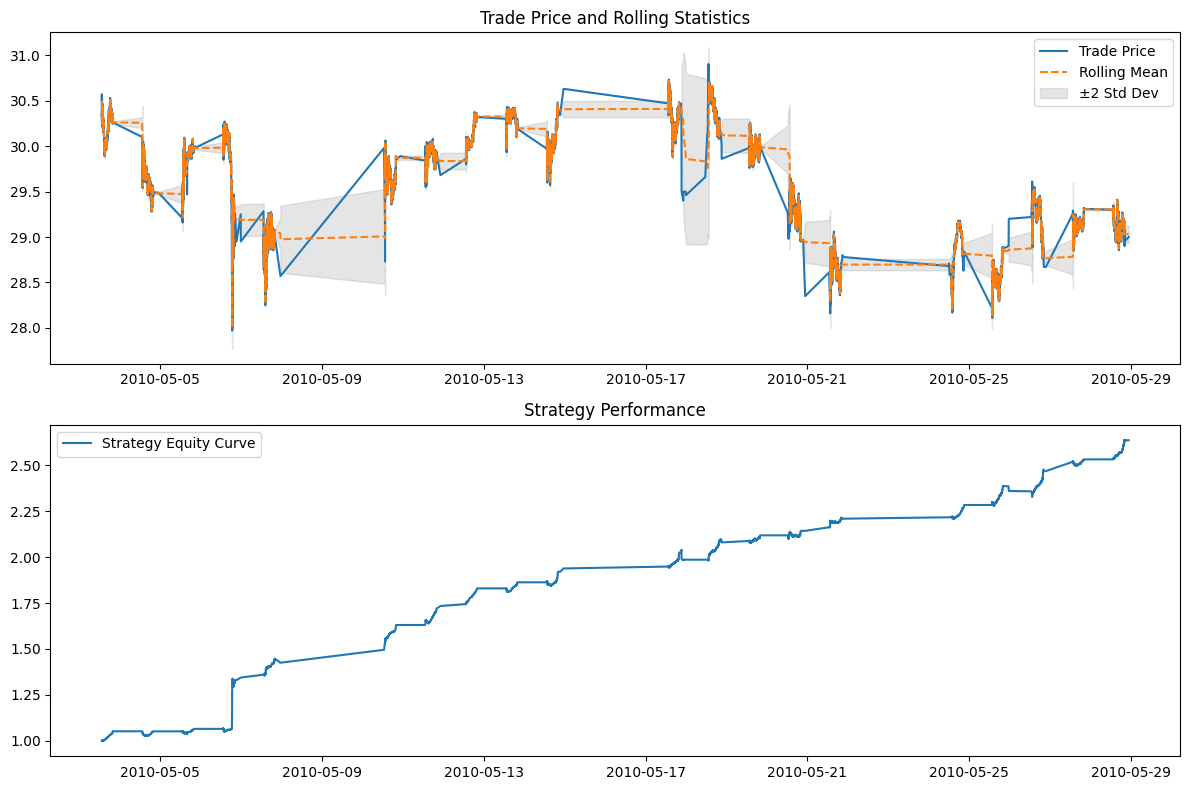

Total Return: 163.57%
Sharpe Ratio: 0.34


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def mean_reversion_strategy(file_path, rolling_window=30, z_entry=2, z_exit=0.5):
    """
    Mean Reversion Strategy with parameters.
    
    Parameters:
        file_path (str): Path to the CSV file containing data.
        rolling_window (int): Rolling window size for mean and standard deviation.
        z_entry (float): Z-score threshold to enter a position (long/short).
        z_exit (float): Z-score threshold to exit a position.
        transaction_cost (float): Cost per trade as a fraction (e.g., 0.001 for 0.1%).

    Returns:
        pd.DataFrame: DataFrame with strategy calculations.
        float: Total return of the strategy.
        float: Sharpe ratio of the strategy.
    """
    # Load and preprocess data
    df = pd.read_csv(file_path)
    df['xltime'] = pd.to_datetime(df['xltime'], errors='coerce')
    df.dropna(subset=['xltime'], inplace=True)
    df.set_index('xltime', inplace=True)

    # Calculate rolling statistics
    df['RollingMean'] = df['trade-price'].rolling(window=rolling_window).mean()
    df['RollingStd'] = df['trade-price'].rolling(window=rolling_window).std()

    # Calculate Z-score
    df['Z-Score'] = (df['trade-price'] - df['RollingMean']) / df['RollingStd']

    # Define trading signals
    df['Position'] = 0
    df.loc[df['Z-Score'] > z_entry, 'Position'] = -1  # Go Short position
    df.loc[df['Z-Score'] < -z_entry, 'Position'] = 1  # Enter Long position
    df.loc[df['Z-Score'].abs() < z_exit, 'Position'] = 0  # Exit position
    df['Position'] = df['Position'].ffill().fillna(0)

    # Calculate returns
    df['DailyReturn'] = df['trade-price'].pct_change()
    df['StrategyReturn'] = df['DailyReturn'] * df['Position'].shift(1)

    # Performance Metrics
    total_return = (1 + df['StrategyReturn']).cumprod().iloc[-1] - 1
    sharpe_ratio = df['StrategyReturn'].mean() / df['StrategyReturn'].std() * np.sqrt(252)  # Annualized

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['trade-price'], label='Trade Price')
    plt.plot(df.index, df['RollingMean'], label='Rolling Mean', linestyle='--')
    plt.fill_between(df.index, df['RollingMean'] - z_entry*df['RollingStd'],df['RollingMean'] + z_entry*df['RollingStd'], color='gray', alpha=0.2, label=f'±{z_entry} Std Dev')
    plt.legend()
    plt.title('Trade Price and Rolling Statistics')

    plt.subplot(2, 1, 2)
    plt.plot(df.index, (1 + df['StrategyReturn']).cumprod(), label='Strategy Equity Curve')
    plt.legend()
    plt.title('Strategy Performance')
    plt.tight_layout()
    plt.show()

    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    return df, total_return, sharpe_ratio

# Example usage
file_path = 'data/UNH_2010_05.csv'

rolling_window = 30
z_entry = 2
z_exit = 0.5

result_df, total_return, sharpe_ratio = mean_reversion_strategy(
    file_path, 
    rolling_window=rolling_window, 
    z_entry=z_entry,
    z_exit=z_exit, 
)
